In [1]:
from lib.utils.config import Config

with Config:
    Config.OUTPUT_DIR = ''
    Config.LOG_DIR = ''
    Config.DATA_DIR = ''
    Config.GPUS = '0'
    Config.WORKERS = 0
    Config.PRINT_FREQ = 20

    # Cudnn related params
    Config.CUDNN.BENCHMARK = True
    Config.CUDNN.DETERMINISTIC = False
    Config.CUDNN.ENABLED = True
    
    # common params for NETWORK
    Config.MODEL.NAME = 'pose_resnet'
    Config.MODEL.INIT_WEIGHTS = True
    Config.MODEL.PRETRAINED = ''
    Config.MODEL.NUM_JOINTS = 17 #17 for coco, 16 for mpii
    Config.MODEL.IMAGE_SIZE = [288,384]  # width * height, ex: 192 * 256
    Config.MODEL.EXTRA.NUM_LAYERS = 50
    Config.MODEL.EXTRA.DECONV_WITH_BIAS = False
    Config.MODEL.EXTRA.NUM_DECONV_LAYERS = 3
    Config.MODEL.EXTRA.NUM_DECONV_FILTERS = [256, 256, 256]
    Config.MODEL.EXTRA.NUM_DECONV_KERNELS = [4, 4, 4]
    Config.MODEL.EXTRA.FINAL_CONV_KERNEL = 1
    Config.MODEL.EXTRA.TARGET_TYPE = 'gaussian'
    Config.MODEL.EXTRA.HEATMAP_SIZE = [64, 64]  # width * height, ex: 24 * 32
    Config.MODEL.EXTRA.SIGMA = 2

    Config.MODEL.STYLE = 'pytorch' #caffe or pytorch

    Config.LOSS.USE_TARGET_WEIGHT = True

    # DATASET related params
    Config.DATASET.ROOT = r'data\coco'
    Config.DATASET.DATASET = 'coco' # mpii or coco
    Config.DATASET.TRAIN_SET = 'train2017'
    Config.DATASET.TEST_SET = 'val2017'
    Config.DATASET.DATA_FORMAT = 'jpg'
    Config.DATASET.HYBRID_JOINTS_TYPE = ''
    Config.DATASET.SELECT_DATA = False

    # training data augmentation
    Config.DATASET.FLIP = True
    Config.DATASET.SCALE_FACTOR = 0.25
    Config.DATASET.ROT_FACTOR = 30

    # train
    Config.TRAIN.LR_FACTOR = 0.1
    Config.TRAIN.LR_STEP = [90, 110]
    Config.TRAIN.LR = 0.001

    Config.TRAIN.OPTIMIZER = 'adam'
    Config.TRAIN.MOMENTUM = 0.9
    Config.TRAIN.WD = 0.0001
    Config.TRAIN.NESTEROV = False
    Config.TRAIN.GAMMA1 = 0.99
    Config.TRAIN.GAMMA2 = 0.0

    Config.TRAIN.BEGIN_EPOCH = 0
    Config.TRAIN.END_EPOCH = 140

    Config.TRAIN.RESUME = False
    Config.TRAIN.CHECKPOINT = ''

    Config.TRAIN.BATCH_SIZE = 32
    Config.TRAIN.SHUFFLE = True

    # testing
    # size of images for each device
    Config.TEST.BATCH_SIZE = 4
    # Test Model Epoch
    Config.TEST.FLIP_TEST = False
    Config.TEST.POST_PROCESS = True
    Config.TEST.SHIFT_HEATMAP = True

    Config.TEST.USE_GT_BBOX = False
    # nms
    Config.TEST.OKS_THRE = 0.5
    Config.TEST.IN_VIS_THRE = 0.0
    Config.TEST.COCO_BBOX_FILE = ''
    Config.TEST.BBOX_THRE = 1.0
    Config.TEST.MODEL_FILE = ''
    Config.TEST.IMAGE_THRE = 0.0
    Config.TEST.NMS_THRE = 1.0

    # debug
    Config.DEBUG.DEBUG = False
    Config.DEBUG.SAVE_BATCH_IMAGES_GT = False
    Config.DEBUG.SAVE_BATCH_IMAGES_PRED = False
    Config.DEBUG.SAVE_HEATMAPS_GT = False
    Config.DEBUG.SAVE_HEATMAPS_PRED = False

In [2]:
from lib.dataset import coco
from lib.models.microsoft_baseline.model import get_pose_net
import torchvision.transforms as transforms

import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
means = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
stds = torch.tensor([0.229, 0.224, 0.225])[:,None,None]

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

t = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

dataset = coco(
        Config,
        Config.DATASET.ROOT,
        Config.DATASET.TEST_SET,
        True,
        t)

dataset = torch.utils.data.DataLoader(
        dataset,
        batch_size=Config.TEST.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.WORKERS,
        pin_memory=True)

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [4]:
iter_dataset = iter(dataset)

In [5]:
data = next(iter_dataset)

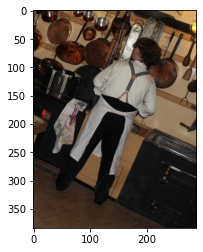

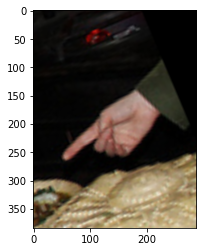

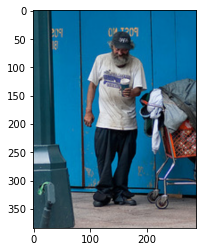

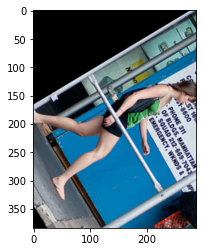

In [6]:
for i in range(Config.TEST.BATCH_SIZE):
    restore_image = data[0][i]
    restore_image = (restore_image*stds+means).permute([1,2,0])[:,:,[2,1,0]]
    plt.imshow(restore_image)
    plt.show()

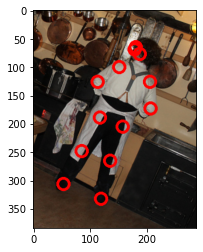

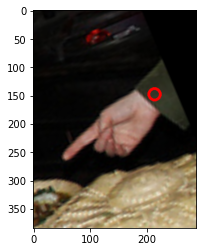

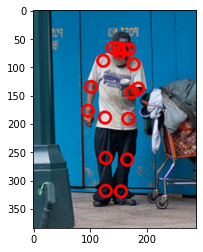

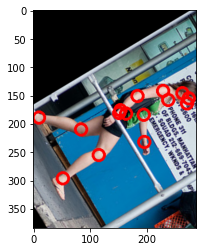

In [7]:
for i in range(Config.TEST.BATCH_SIZE):
    restore_image = data[0][i]
    restore_image = (restore_image*stds+means).permute([1,2,0])[:,:,[2,1,0]]
    copyimage = restore_image.numpy().copy()
    for p,m in zip(data[3]['joints'][i],data[3]['joints_vis'][i]):
        if m[0] == 1:
            cv2.circle(copyimage,np.round(p.numpy()[:2]).astype(int),10,[1,0,0],3)
    plt.imshow(copyimage)
    plt.show()

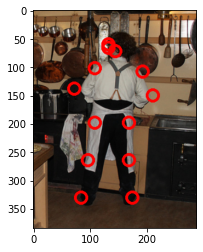

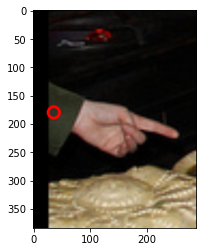

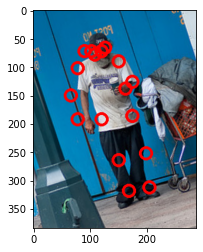

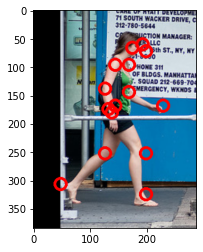

In [60]:
# original_image = plt.imread(r'D:\Portfolio\Golfer_Motion_Tracking\DL_approach\data\coco\images\val2017\000000397133.jpg')
for i in range(Config.TEST.BATCH_SIZE):
    repro = get_final_preds(Config,data[1].numpy()[[i]],np.array([288,384])[None,:]/2,np.array([384,384])[None,:]/200)
    # repro = get_final_preds(Config,data[1].numpy()[[i]],np.array([288,384])[None,:]/2,data[3]['scale'][i].numpy()*1.25)
    # repro = get_final_preds(Config,data[1].numpy(),data[3]['center'].numpy(),data[3]['scale'].numpy())
    restore_image = data[0][i]
    restore_image = (restore_image*stds+means).permute([1,2,0])[:,:,[2,1,0]]
    copyimage = restore_image.numpy().copy()
    # copyimage = original_image.copy()
    for p,m in zip(repro[0][0],repro[1][0]):
        if m[0] == 1:
            cv2.circle(copyimage,np.round(p[:2]).astype(int),10,[1,0,0],3)
    plt.imshow(copyimage)
    plt.show()

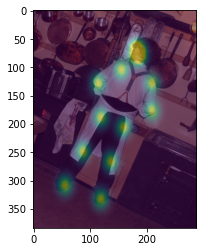

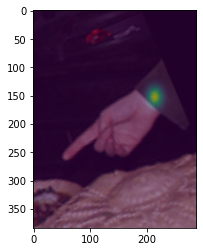

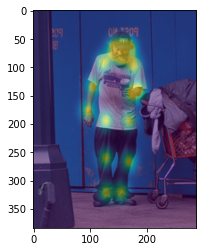

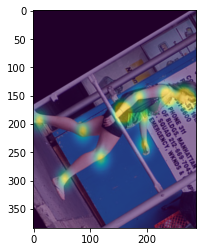

In [8]:
for i in range(Config.TEST.BATCH_SIZE):
    restore_image = data[0][i]
    restore_image = (restore_image*stds+means).permute([1,2,0])[:,:,[2,1,0]]
    plt.imshow(restore_image)
    plt.imshow(cv2.resize(np.clip(data[1][i].numpy().sum(axis=0),0,1),Config.MODEL.IMAGE_SIZE),alpha=0.5)
    plt.show()

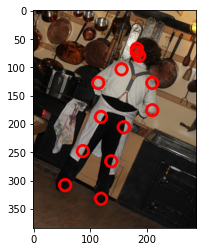

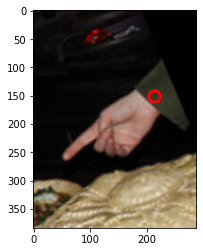

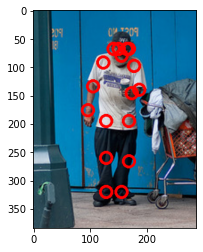

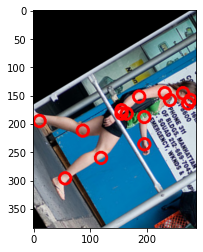

In [11]:
for i in range(Config.TEST.BATCH_SIZE):
    restore_image = data[0][i]
    copyimage = (restore_image*stds+means).permute([1,2,0])[:,:,[2,1,0]].clone().numpy()
    hm = cv2.resize(np.clip(data[1][i].numpy().transpose([1,2,0]),0,1),Config.MODEL.IMAGE_SIZE)
    
    preds, maxvals = get_max_preds(hm.transpose([2,0,1])[None,...])
    
    for p,m in zip(preds[0].astype(int),maxvals[0]):
        if m[0] != 0:
            cv2.circle(copyimage,np.round(p).astype(int),10,[1,0,0],3)
    plt.imshow(copyimage)
    plt.show()

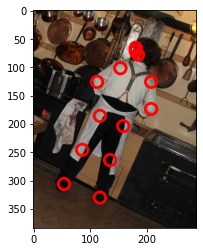

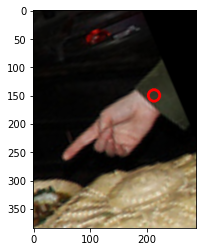

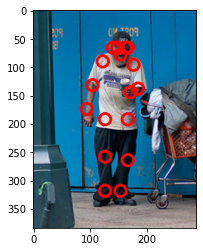

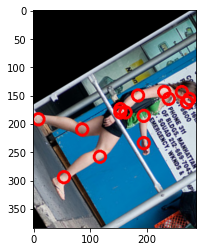

In [16]:
# original_image = plt.imread(r'D:\Portfolio\Golfer_Motion_Tracking\DL_approach\data\coco\images\val2017\000000397133.jpg')
for i in range(Config.TEST.BATCH_SIZE):
    repro = get_final_preds(Config,data[1].numpy()[[i]],np.array([288,384])[None,:]/2,np.array([384,384])[None,:]/200)
    # repro = get_final_preds(Config,data[1].numpy()[[i]],np.array([288,384])[None,:]/2,data[3]['scale'][i].numpy()*1.25)
    # repro = get_final_preds(Config,data[1].numpy(),data[3]['center'].numpy(),data[3]['scale'].numpy())
    restore_image = data[0][i]
    restore_image = (restore_image*stds+means).permute([1,2,0])[:,:,[2,1,0]]
    copyimage = restore_image.numpy().copy()
    # copyimage = original_image.copy()
    for p,m in zip(repro[0][0],repro[1][0]):
        if m[0] == 1:
            cv2.circle(copyimage,np.round(p[:2]).astype(int),10,[1,0,0],3)
    plt.imshow(copyimage)
    plt.show()

In [15]:
import math
# from lib.utils.transforms import transform_preds


def get_max_preds(batch_heatmaps):
    '''
    get predictions from score maps
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    '''
    assert isinstance(batch_heatmaps, np.ndarray), \
        'batch_heatmaps should be numpy.ndarray'
    assert batch_heatmaps.ndim == 4, 'batch_images should be 4-ndim'

    batch_size = batch_heatmaps.shape[0]
    num_joints = batch_heatmaps.shape[1]
    width = batch_heatmaps.shape[3]
    heatmaps_reshaped = batch_heatmaps.reshape((batch_size, num_joints, -1))
    idx = np.argmax(heatmaps_reshaped, 2)
    maxvals = np.amax(heatmaps_reshaped, 2)

    maxvals = maxvals.reshape((batch_size, num_joints, 1))
    idx = idx.reshape((batch_size, num_joints, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)

    preds[:, :, 0] = (preds[:, :, 0]) % width
    preds[:, :, 1] = np.floor((preds[:, :, 1]) / width)

    pred_mask = np.tile(np.greater(maxvals, 0.0), (1, 1, 2))
    pred_mask = pred_mask.astype(np.float32)

    preds *= pred_mask
    return preds, maxvals

def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]

def get_affine_transform():
    # if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
    #     print(scale)
    #     scale = np.array([scale, scale])

    # scale_tmp = scale * 200.0
    # src_w = scale_tmp[0]
    # dst_w = output_size[0]
    # dst_h = output_size[1]

    # rot_rad = np.pi * rot / 180
    # src_dir = get_dir([0, src_w * -0.5], rot_rad)
    # dst_dir = np.array([0, dst_w * -0.5], np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    
    src[0,:] = [0,0]
    src[1,:] = [64,0]
    src[2,:] = [0,64]
    
    dst[0,:] = [0,0]
    dst[1,:] = [288,0]
    dst[2,:] = [0,384]
    
    # src[0, :] = center + scale_tmp * shift
    # src[1, :] = center + src_dir + scale_tmp * shift
    # dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    # dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5]) + dst_dir

    # src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    # dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])
    trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))
    return trans

def transform_preds(coords, center, scale, output_size):
    target_coords = np.zeros(coords.shape)
    # trans = get_affine_transform(center, scale, 0, output_size, inv=1)
    trans = get_affine_transform()
    for p in range(coords.shape[0]):
        target_coords[p, 0:2] = affine_transform(coords[p, 0:2], trans)
    return target_coords



def get_final_preds(config, batch_heatmaps, center, scale):
    coords, maxvals = get_max_preds(batch_heatmaps)

    heatmap_height = batch_heatmaps.shape[2]
    heatmap_width = batch_heatmaps.shape[3]

    # post-processing
    if config.TEST.POST_PROCESS:
        for n in range(coords.shape[0]):
            for p in range(coords.shape[1]):
                hm = batch_heatmaps[n][p]
                px = int(math.floor(coords[n][p][0] + 0.5))
                py = int(math.floor(coords[n][p][1] + 0.5))
                if 1 < px < heatmap_width-1 and 1 < py < heatmap_height-1:
                    diff = np.array([hm[py][px+1] - hm[py][px-1],hm[py+1][px]-hm[py-1][px]])
                    coords[n][p] += np.sign(diff) * .25

    preds = coords.copy()

    # Transform back
    for i in range(coords.shape[0]):
        preds[i] = transform_preds(coords[i], center[i], scale[i], [heatmap_width, heatmap_height])

    return preds, maxvals


In [61]:
from pycocotools.coco import COCO

coco = COCO(r'D:\Portfolio\Golfer_Motion_Tracking\DL_approach\data\coco\annotations\person_keypoints_val2017.json')

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [70]:
coco.loadImgs(397133)

[{'license': 4,
  'file_name': '000000397133.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
  'height': 427,
  'width': 640,
  'date_captured': '2013-11-14 17:02:52',
  'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
  'id': 397133}]

In [72]:
anns = coco.loadAnns(coco.getAnnIds(397133))

In [77]:
np.array(anns[0]['keypoints']).reshape((-1,3))

array([[433,  94,   2],
       [434,  90,   2],
       [  0,   0,   0],
       [443,  98,   2],
       [  0,   0,   0],
       [420, 128,   2],
       [474, 133,   2],
       [396, 162,   2],
       [489, 173,   2],
       [  0,   0,   0],
       [  0,   0,   0],
       [419, 214,   2],
       [458, 215,   2],
       [411, 274,   2],
       [458, 273,   2],
       [402, 333,   2],
       [465, 334,   2]])

(array([[[ 22.5, 142.5],
         [ 18. , 138. ],
         [  0. ,  48. ],
         [ 31.5, 138. ],
         [  0. ,  48. ],
         [ 45. , 169.5],
         [ 90. , 129. ],
         [ 63. , 205.5],
         [139.5, 138. ],
         [  0. ,  48. ],
         [  0. ,  48. ],
         [135. , 214.5],
         [162. , 183. ],
         [189. , 250.5],
         [220.5, 214.5],
         [243. , 286.5],
         [283.5, 237. ]]], dtype=float32),
 array([[[1.       ],
         [1.       ],
         [0.       ],
         [1.       ],
         [0.       ],
         [1.       ],
         [1.       ],
         [1.       ],
         [1.       ],
         [0.       ],
         [0.       ],
         [1.       ],
         [1.       ],
         [1.       ],
         [1.       ],
         [1.       ],
         [0.8824969]]], dtype=float32))

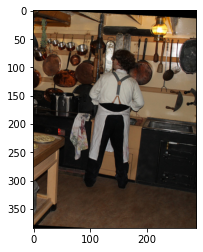

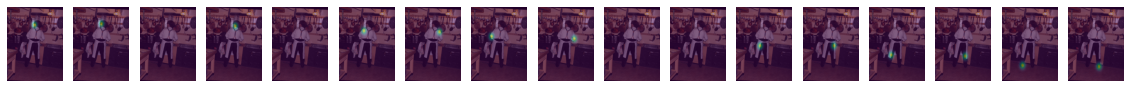

In [39]:


gt_heatmap = data[1][0]

plt.subplots(1,17,figsize=(20,20*17))
for i,hm in enumerate(gt_heatmap):
    plt.subplot(1,17,i+1)
    plt.imshow(restore_image)
    plt.imshow(cv2.resize(hm.numpy(),Config.MODEL.IMAGE_SIZE),alpha=0.5)
    plt.axis(False)
plt.show()

In [21]:
model = get_pose_net(Config,False)
model.load_state_dict(torch.load(r'pose_resnet_50_384x288.pth.tar'))
model = model.eval()
model

In [ ]:
with torch.no_grad():
    pred = model(data[0][None,...])

In [ ]:
heatmap = data[1][0]
plt.figure(figsize=(30,30*17))
plt.imshow(torch.concat(gt_heatmap.split(1),axis=2).squeeze(),cmap='gray')
plt.show()

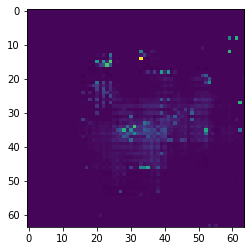

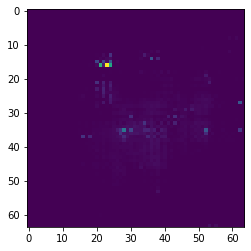

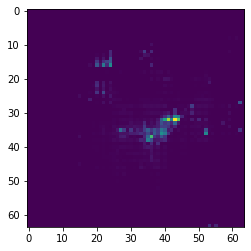

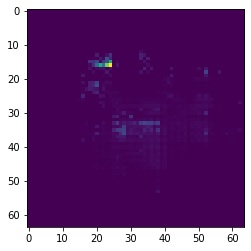

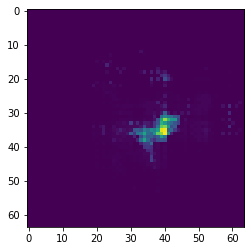

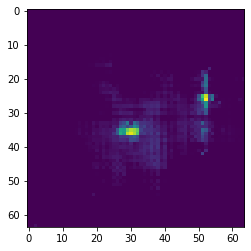

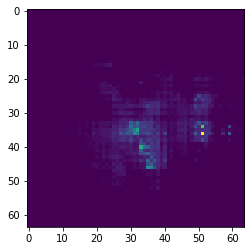

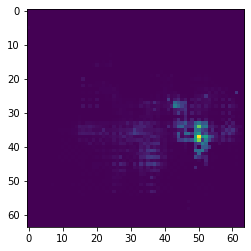

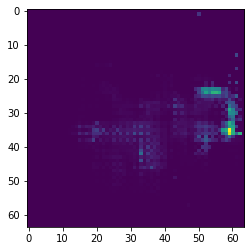

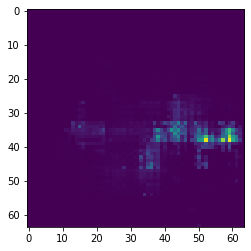

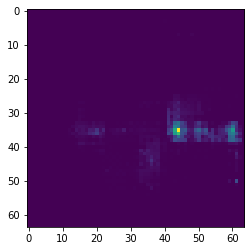

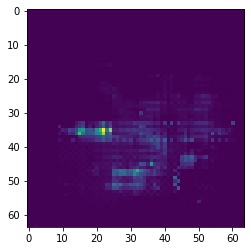

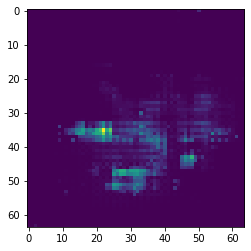

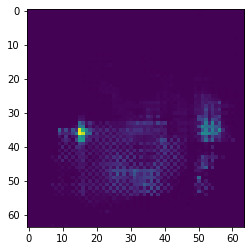

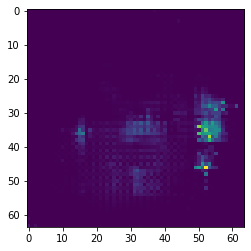

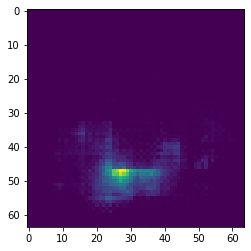

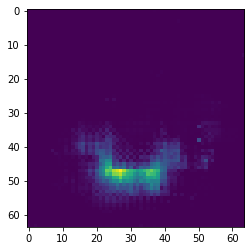

In [47]:
for j in pred[0]:
    plt.imshow(torch.clip(j,0,1))
    plt.show()

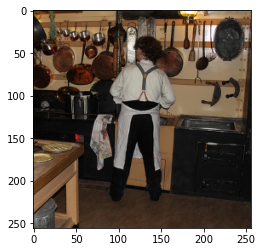

In [49]:
plt.imshow(restore_image[:,:,[2,1,0]])

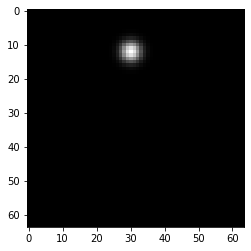

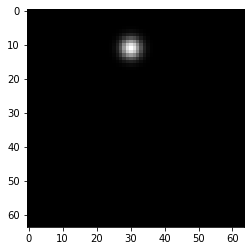

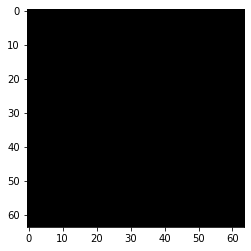

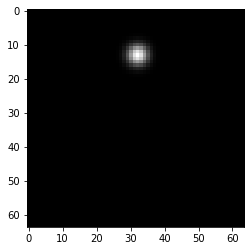

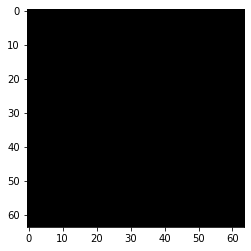

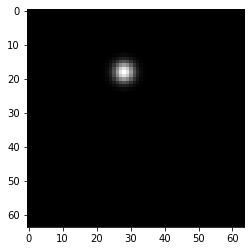

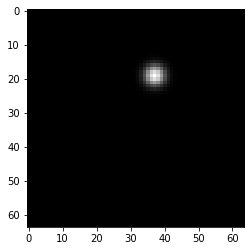

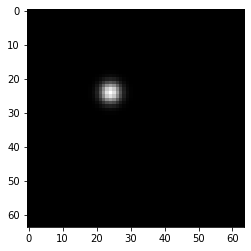

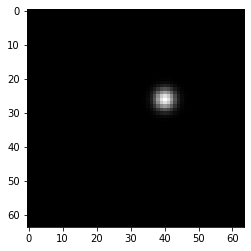

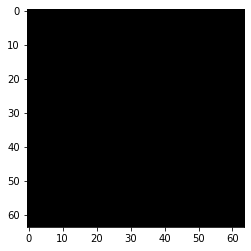

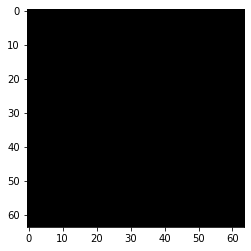

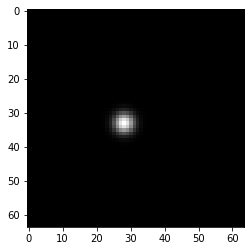

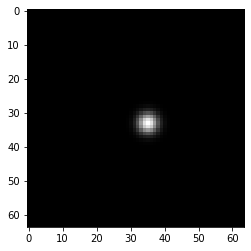

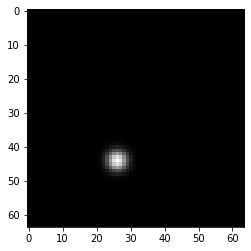

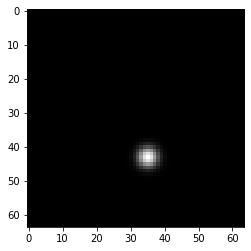

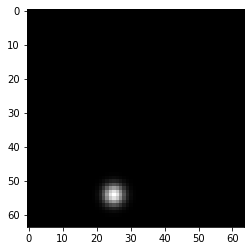

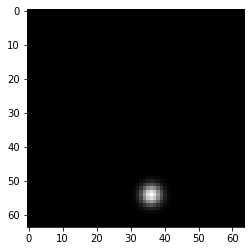

In [50]:
for i in data[1]:
    plt.imshow(i,cmap='gray')
    plt.show()